In [2]:
import numpy as np
import os
import re
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4

from run_realization_v2 import setup_submit_wait
from DA_operators import operator_clm_SMAP, operator_clm_FLX

import multiprocessing as mp

from itertools import repeat
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time
import sys
import pickle
import copy
from helpers import save_dict_to_pickle, load_dict_from_pickle

# folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter3_FLXOnly'
# folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter7'
folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5'
# folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v12_3m_xy16_loc16_a16_dzeta04_iter3_FLXv2'
if folder_results not in sys.path:
    sys.path.insert(0,os.path.join(folder_results,'settings'))
from settings_copy import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap,date_start,date_end
settings_run['remove_hist_files'] = False

dir_figs = os.path.join(folder_results,'figures/03_correlations')
if not os.path.exists(dir_figs):
    print('Creating folder to store gridded SMAP mismatch: %s' % (dir_figs) )
    os.makedirs(dir_figs)
    
i_iter = 5

date_plot = [datetime(2019,1,1),datetime(2019,12,31),datetime(2020,1,1),datetime(2020,12,31)]

pickle_filename = os.path.join(dir_figs,'plot_03_correlations.pickle')
pickle_filename2 = os.path.join(dir_figs,'plot_03_mismatch_lat_timeseries.pickle')

# Change if necessary to storage folder
# settings_run['dir_setup'] = '/p/largedata/jibg36/kaandorp2/run_data/DA_eCLM_cordex_444x432_v14_1y_iter3_FLXOnly'
# settings_run['dir_setup'] = '/p/largedata/jibg36/kaandorp2/run_data/DA_eCLM_cordex_444x432_v15_1y_iter5_SMAPOnly'
settings_run['dir_setup'] = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5'
# settings_run['dir_setup'] = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter1'

stats_save = {}
stats_save['SMAP'] = {}
stats_save['FLX'] = {}

In [3]:
settings_DA

{'param_setup': [<function setup_parameters.setup_orgmax_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_fff(settings_setup, settings_run)>,
  <function setup_parameters.setup_h2o_canopy_max(settings_setup, settings_run)>,
  <function setup_parameters.setup_mineral_hydraulic(settings_setup, settings_run)>,
  <function setup_parameters.setup_om_hydraulic(settings_setup, settings_run)>,
  <function setup_parameters.setup_kmax_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_medlyn_slope_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_medlyn_intercept_v2(settings_setup, settings_run)>,
  <function setup_parameters.setup_luna(settings_setup, settings_run)>,
  <function setup_parameters.setup_sandfrac_anom(settings_gen, settings_run)>,
  <function setup_parameters.setup_clayfrac_anom(settings_gen, settings_run)>,
  <function setup_parameters.setup_orgfrac_anom(settings_gen, settings_run)>],
 'param_gen': [<function generate_pa

In [4]:
i_date = 0
date_results_iter = date_results_binned[i_date].copy()
date_start_sim = date_results_binned[i_date][0][0]
date_end_sim = date_results_binned[i_date][-1][-1]

# for the plots include the validation timespan
date_validation_start = date_results_iter[-1][-1]
date_results_iter.append(list(date_range_noleap(date_validation_start,
                                                date_validation_start+timedelta(days=settings_run['ndays_validation']),freq=freq_output)))

operator = {}
operator['SMAP'] = operator_clm_SMAP(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_SMAP'],ignore_rivers=False)
smap_vals,_,smap_latlon,smap_dates = operator['SMAP'].get_measurements(date_results_iter,date_DA_start=date_start_sim,return_latlon=True,return_date=True)
operator['FLX'] = operator_clm_FLX(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_FLX'],ignore_rivers=False)
flx_vals,_,flx_latlon,flx_dates = operator['FLX'].get_measurements(date_results_iter,date_DA_start=date_start_sim,return_latlon=True,return_date=True)

Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-21 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-24 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-27 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-06-30 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-07-03 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-06-19 12:00:00, TSMP: 2019-07-06 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-07-24 12:00:00, TSMP: 2019-07-09 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-07-24 12:00:00, TSMP: 2019-07-12 20:00:00
Measurement and model output differ more than a day, SMAP: 2019-07-24 12:00:00, TSMP: 2019-07-15 20:00:00
Measurement and model output differ more than 

In [5]:
# i_iter = 1
dir_setup = settings_run['dir_setup']
str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
dir_date = os.path.join(dir_setup,str_date)
str_iter = 'i%3.3i' % i_iter
dir_iter = os.path.join(dir_date,str_iter)
settings_run['dir_iter'] = dir_iter

results = {}
i_DA = 0
i_OL = int(sorted(glob(os.path.join(dir_iter,'*')))[-1][-3:]) # the OL simulation

date_val = date_results_iter[0][-1]
date_end = date_results_iter[1][-1]

print(i_DA,i_OL)
for i_real in [i_DA,i_OL]:
    results[i_real] = {}
    _ = operator['SMAP'].interpolate_model_results(i_real,settings_run,indices_z=[0,1],var='SOILLIQ')
    _ = operator['FLX'].interpolate_model_results(i_real,settings_run,retain_history=True)
        
    results[i_real]['SMAP'] = operator['SMAP'].data_TSMP_i
    results[i_real]['FLX'] = operator['FLX'].data_TSMP_i
    
    
grid = {}
grid['background'] = (operator['SMAP'].grid_TSMP['lsm']==2).values
grid['lat_c'] = operator['SMAP'].grid_TSMP['lat_corner'].values
grid['lon_c'] = operator['SMAP'].grid_TSMP['lon_corner'].values

save_dict_to_pickle(grid,os.path.join(dir_figs,'grid.pickle'))

0 63
2 matching files found (['/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i005/R000/run_20190101-20191230/EU11.clm2.h0.2019-12-30-72000.nc', '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i005/R000/run_20191230-20201228/EU11.clm2.h0.2019-12-30-72000.nc']), taking the last file
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i005/R000/data_FLX.pickle
2 matching files found (['/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i005/R063/run_20190101-20191230/EU11.clm2.h0.2019-12-30-72000.nc', '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i005/R063/run_20191230-20201228/EU11.clm2.h0.2019-12-30-72000.nc']), taking the last file
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTS

# SMAP

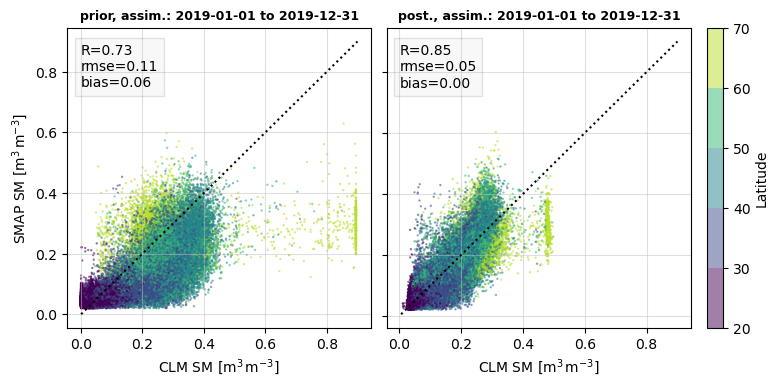

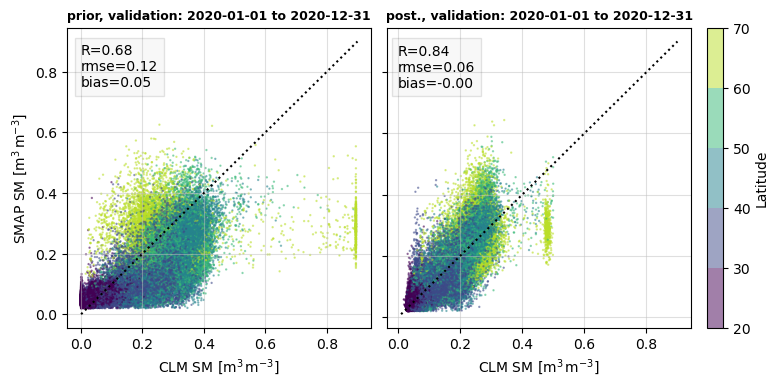

In [6]:
# date_start = pd.Timestamp(2019,5,1)
# date_start = date_start#.copy()
# date_val = date_end#.copy() #pd.Timestamp(2019,8,1)
# i_val = np.where(smap_dates > date_val)[0][0]
# i_OL = list(results.keys())[-1]
# i_DA = list(results.keys())[0]
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as mcolors
# Define the original colormap
original_cmap = plt.cm.viridis
# Extract colormap colors
colors = original_cmap(np.linspace(0, 1, 256))
# Create a truncated colormap, excluding the upper 20%
truncated_colors = colors[int(0.0 * len(colors)):int(0.9 * len(colors))]
# Create a new colormap with the truncated colors
truncated_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_inferno', truncated_colors)

i_val = np.where(smap_dates > date_val)[0][0]

lats_select = np.array([20,30,40,50,60,70])

cmap = truncated_cmap#plt.cm.viridis
norm = mpl.colors.BoundaryNorm(lats_select, cmap.N)


### Training
fig = plt.figure(figsize=(8,4))
# fig.subplots_adjust(right=0.9,top=0.9)

ax1 = fig.add_axes([0.10, 0.15, 0.38, 0.75])
ax2 = fig.add_axes([0.50, 0.15, 0.38, 0.75])
cax = fig.add_axes([0.9, 0.15, 0.02, 0.75])


# prior, training
y_all = smap_vals[:i_val]
x_all = operator['SMAP'].flatten_y(results[i_OL]['SMAP'])[:i_val]
lats_all = smap_latlon[:,0][:i_val]
min_ = min(min(x_all),min(y_all))
max_ = .9#max(max(x_all),max(y_all))
R = pearsonr(x_all,y_all)[0]
rmse = np.sqrt(np.mean((x_all-y_all)**2))
bias = np.mean(x_all-y_all)    
color_ = np.digitize(lats_all,lats_select)
mask = np.random.choice([0,1],len(color_),p=[0.99,0.01]).astype(bool)
stats_save['SMAP']['train_prior'] = {}
stats_save['SMAP']['train_prior']['rmse'] = rmse
stats_save['SMAP']['train_prior']['R'] = R
stats_save['SMAP']['train_prior']['bias'] = bias


ax1.grid(color='silver', alpha=0.5)
scat=ax1.scatter(x_all[mask],y_all[mask],s=.5,alpha=.5,c=lats_all[mask],cmap=cmap,norm=norm)
ax1.plot([min_,max_],[min_,max_],'k:')
ax1.set_xlabel(r'CLM SM [m$^3\,$m$^{-3}$]')
ax1.set_ylabel(r'SMAP SM [m$^3\,$m$^{-3}$]')
t1 = ax1.text(.0,.75,'R=%.2f\nrmse=%.2f\nbias=%.2f' % (R,rmse,bias))
t1.set_bbox(dict(facecolor='silver', alpha=0.1, edgecolor='k'))

# DA (posterior), training
y_all = smap_vals[:i_val]
x_all = operator['SMAP'].flatten_y(results[i_DA]['SMAP'])[:i_val]
lats_all = smap_latlon[:,0][:i_val]
min_ = min(min(x_all),min(y_all))
max_ = .9#max(max(x_all),max(y_all))
R = pearsonr(x_all,y_all)[0]
rmse = np.sqrt(np.mean((x_all-y_all)**2))
bias = np.mean(x_all-y_all)    
color_ = np.digitize(lats_all,lats_select)
mask = np.random.choice([0,1],len(color_),p=[0.99,0.01]).astype(bool)
stats_save['SMAP']['train_post'] = {}
stats_save['SMAP']['train_post']['rmse'] = rmse
stats_save['SMAP']['train_post']['R'] = R
stats_save['SMAP']['train_post']['bias'] = bias

ax2.grid(color='silver', alpha=0.5)
scat2=ax2.scatter(x_all[mask],y_all[mask],s=.5,alpha=.5,c=lats_all[mask],cmap=cmap,norm=norm)
ax2.plot([min_,max_],[min_,max_],'k:')
ax2.set_xlabel(r'CLM SM [m$^3\,$m$^{-3}$]')
# ax2.set_ylabel(r'SMAP SM [mm$^3$ mm$^{-3}$]')
ax2.tick_params(labelleft=False)
t2 = ax2.text(.0,.75,'R=%.2f\nrmse=%.2f\nbias=%.2f' % (R,rmse,bias))
t2.set_bbox(dict(facecolor='silver', alpha=0.1, edgecolor='k'))

ax1.set_title('prior, assim.: %s to %s' % (str(date_plot[0])[0:10],str(date_plot[1])[0:10]),weight="bold",fontsize=9)
ax2.set_title('post., assim.: %s to %s' % (str(date_plot[0])[0:10],str(date_plot[1])[0:10]),weight="bold",fontsize=9)

cbar = plt.colorbar(scat,cax=cax)
cbar.set_label(r'Latitude',labelpad=3)

fig.savefig(os.path.join(dir_figs,'corr_SMAP_training.png') )
fig.savefig(os.path.join(dir_figs,'corr_SMAP_training.pdf') )



### Validation
fig = plt.figure(figsize=(8,4))
# fig.subplots_adjust(right=0.9,top=0.9)

ax1 = fig.add_axes([0.10, 0.15, 0.38, 0.75])
ax2 = fig.add_axes([0.50, 0.15, 0.38, 0.75])
cax = fig.add_axes([0.9, 0.15, 0.02, 0.75])


# prior, validation
y_all = smap_vals[i_val:]
x_all = operator['SMAP'].flatten_y(results[i_OL]['SMAP'])[i_val:]
lats_all = smap_latlon[:,0][i_val:]
min_ = min(min(x_all),min(y_all))
max_ = .9#max(max(x_all),max(y_all))
R = pearsonr(x_all,y_all)[0]
rmse = np.sqrt(np.mean((x_all-y_all)**2))
bias = np.mean(x_all-y_all)    
color_ = np.digitize(lats_all,lats_select)
mask = np.random.choice([0,1],len(color_),p=[0.99,0.01]).astype(bool)
stats_save['SMAP']['val_prior'] = {}
stats_save['SMAP']['val_prior']['rmse'] = rmse
stats_save['SMAP']['val_prior']['R'] = R
stats_save['SMAP']['val_prior']['bias'] = bias

ax1.grid(color='silver', alpha=0.5)
scat=ax1.scatter(x_all[mask],y_all[mask],s=.5,alpha=.5,c=lats_all[mask],cmap=cmap,norm=norm)
ax1.plot([min_,max_],[min_,max_],'k:')
ax1.set_xlabel(r'CLM SM [m$^3\,$m$^{-3}$]')
ax1.set_ylabel(r'SMAP SM [m$^3\,$m$^{-3}$]')
t1 = ax1.text(.0,.75,'R=%.2f\nrmse=%.2f\nbias=%.2f' % (R,rmse,bias))
t1.set_bbox(dict(facecolor='silver', alpha=0.1, edgecolor='k'))


# posterior, validation
y_all = smap_vals[i_val:]
x_all = operator['SMAP'].flatten_y(results[i_DA]['SMAP'])[i_val:]
lats_all = smap_latlon[:,0][i_val:]
min_ = min(min(x_all),min(y_all))
max_ = .9#max(max(x_all),max(y_all))
R = pearsonr(x_all,y_all)[0]
rmse = np.sqrt(np.mean((x_all-y_all)**2))
bias = np.mean(x_all-y_all)    
color_ = np.digitize(lats_all,lats_select)
mask = np.random.choice([0,1],len(color_),p=[0.99,0.01]).astype(bool)
stats_save['SMAP']['val_post'] = {}
stats_save['SMAP']['val_post']['rmse'] = rmse
stats_save['SMAP']['val_post']['R'] = R
stats_save['SMAP']['val_post']['bias'] = bias

ax2.grid(color='silver', alpha=0.5)
scat2=ax2.scatter(x_all[mask],y_all[mask],s=.5,alpha=.5,c=lats_all[mask],cmap=cmap,norm=norm)
ax2.plot([min_,max_],[min_,max_],'k:')
ax2.set_xlabel(r'CLM SM [m$^3\,$m$^{-3}$]')
# ax2.set_ylabel(r'SMAP SM [mm$^3$ mm$^{-3}$]')
ax2.tick_params(labelleft=False)
t2 = ax2.text(.0,.75,'R=%.2f\nrmse=%.2f\nbias=%.2f' % (R,rmse,bias))
t2.set_bbox(dict(facecolor='silver', alpha=0.1, edgecolor='k'))

ax1.set_title('prior, validation: %s to %s' % (str(date_plot[2])[0:10],str(date_plot[3])[0:10]),weight="bold",fontsize=9)
ax2.set_title('post., validation: %s to %s' % (str(date_plot[2])[0:10],str(date_plot[3])[0:10]),weight="bold",fontsize=9)

cbar = plt.colorbar(scat,cax=cax)
cbar.set_label(r'Latitude',labelpad=3)

fig.savefig(os.path.join(dir_figs,'corr_SMAP_val.png') )
fig.savefig(os.path.join(dir_figs,'corr_SMAP_val.pdf') )



# fig = plt.figure(figsize=(8,8))
# ax1 = fig.add_axes([0.06, 0.5, 0.4, 0.4])
# ax2 = fig.add_axes([0.48, 0.5, 0.4, 0.4])
# ax3 = fig.add_axes([0.06, 0.06, 0.4, 0.4],projection=proj)
# ax4 = fig.add_axes([0.48, 0.06, 0.4, 0.4],projection=proj)
# cax = fig.add_axes([0.9, 0.1, 0.02, 0.75])

# FLX

BE-Lon
BE-Vie
CH-Cha
CZ-BK1
CZ-KrP
CZ-RAJ
CZ-wet
DE-Geb
DE-Gri
DE-Hai
DE-HoH
DE-Hzd
DE-Kli
DE-Obe
DE-RuR
DE-RuS
DE-Tha
ES-Abr
ES-Cnd
ES-LJu
ES-LM1
ES-LM2
FI-Hyy
FI-Let
FI-Var
FR-Aur
FR-Bil
FR-Gri
FR-Hes
FR-Lam
FR-Tou
IE-Cra
IL-Yat
IT-BCi
IT-BFt
IT-Cp2
IT-Lsn
IT-MBo
IT-SR2
IT-Tor
RU-Fy2
RU-Fyo
SE-Deg
SE-Htm
SE-Nor
SE-Ros
SE-Svb
MXF, R=0.855350, rmse=0.838102, bias=0.311009
GRA, R=0.857266, rmse=0.773558, bias=-0.132518
ENF, R=0.827321, rmse=0.672105, bias=0.052193
XX, R=0.898908, rmse=0.723633, bias=-0.332638
WET, R=0.838485, rmse=1.021765, bias=-0.253268
CRO, R=0.713657, rmse=1.032384, bias=-0.072804
DBF, R=0.843944, rmse=0.880616, bias=0.208399
SAV, R=0.710829, rmse=0.868273, bias=0.314389
WSA, R=0.385725, rmse=0.971596, bias=0.349997
OSH, R=0.900640, rmse=1.068064, bias=0.437576
Realization 63
all landcovers: R=0.805010, rmse=0.829787, bias=0.048656
BE-Lon
BE-Vie
CH-Cha
CZ-BK1
CZ-KrP
CZ-RAJ
CZ-wet
DE-Geb
DE-Gri
DE-Hai
DE-HoH
DE-Hzd
DE-Kli
DE-Obe
DE-RuR
DE-RuS
DE-Tha
ES-Abr
ES-Cnd
ES-

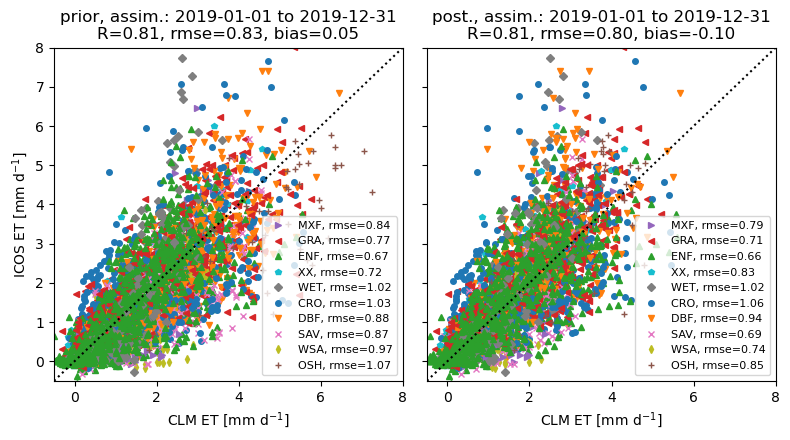

In [7]:
### Training, prior & posterior

%matplotlib inline

# fig = plt.figure(figsize=(8,4))
# # fig.subplots_adjust(right=0.9,top=0.9)
# ax1 = fig.add_axes([0.10, 0.15, 0.38, 0.75])
# ax2 = fig.add_axes([0.50, 0.15, 0.38, 0.75])
# # cax = fig.add_axes([0.9, 0.15, 0.02, 0.75])

# fig2 = plt.figure(figsize=(8,4))
# axes = [[],[]]
# axes[0] = fig.add_axes([0.10, 0.15, 0.38, 0.75])
# axes[1] = fig.add_axes([0.50, 0.15, 0.38, 0.75])
stats_per_station = {}
stats_per_station['train'] = {}
stats_per_station['val'] = {}
stats_per_station['date_start'] = date_start
stats_per_station['date_val'] = date_val
stats_per_station['date_end'] = date_end

fig,axes = plt.subplots(1,2,figsize=(8,4.5))

modes = ['prior','post.']
keys_save = ['train_prior','train_post']
for i_,i_real in enumerate([i_OL,i_DA]):
    
    mode_ = modes[i_]
    key_save = keys_save[i_]
    stats_per_station['train'][mode_] = {}
    x_cover = {}
    y_cover = {}
    n_cover = {}
    list_covers = [operator['FLX'].data_flx[station_]['landcover'] for station_ in operator['FLX'].data_flx.keys()]
    covers_unique = np.unique(list_covers)
    cmap = plt.cm.tab10
    markers = ["o", "v", "^", "<", ">", "+", "x", "D", "d", "p", "P","1", "2", "3", "4", "s", "*", "h", "H", "X" ]

    x_all = np.array([])
    y_all = np.array([])
    
    for station_ in operator['FLX'].data_flx.keys():
        print(station_)
        cover = operator['FLX'].data_flx[station_]['landcover']
        i_cover = np.where(cover==covers_unique)[0][0]

        dates = np.array(list(results[i_real]['FLX'][station_].keys()))
        
        if dates[-1] > date_val:
            
            i_date_start = np.where(dates > date_val)[0][0]

            x_ = np.array([float(results[i_real]['FLX'][station_][key_]) for key_ in results[i_real]['FLX'][station_].keys()])[:i_date_start]
            y_ = np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[:i_date_start]
            if cover not in x_cover:
                x_cover[cover] = np.array([])
                y_cover[cover] = np.array([])
                n_cover[cover] = 0
                label_ = cover
            else:
                label_ = None

            x_cover[cover] = np.append(x_cover[cover],x_)
            y_cover[cover] = np.append(y_cover[cover],y_)

            axes[i_].plot(x_,y_,markers[i_cover],markersize=4,color=cmap(i_cover),label=label_)

            if len(x_) > 1:
                x_all = np.append(x_all,x_)
                y_all = np.append(y_all,y_)
                stats_per_station['train'][mode_][station_] = {}
                stats_per_station['train'][mode_][station_]['x'] = x_
                stats_per_station['train'][mode_][station_]['x'] = y_
                stats_per_station['train'][mode_][station_]['rmse'] = np.sqrt(np.mean((x_-y_)**2))
                stats_per_station['train'][mode_][station_]['R'] = pearsonr(x_,y_)[0]
                stats_per_station['train'][mode_][station_]['bias'] = np.mean(x_-y_)

                stats_per_station['train'][mode_][station_]['lat'] = operator['FLX'].data_flx[station_]['lat']
                stats_per_station['train'][mode_][station_]['lon'] = operator['FLX'].data_flx[station_]['lon']
                stats_per_station['train'][mode_][station_]['cover'] = cover
            n_cover[cover] += 1

    handles,labels_ = axes[i_].get_legend_handles_labels()
    for i1,cover_ in enumerate(labels_):
        R = pearsonr(x_cover[cover_],y_cover[cover_])[0]
        rmse = np.sqrt(np.mean((x_cover[cover_]-y_cover[cover_])**2))
        bias = np.mean(x_cover[cover_]-y_cover[cover_])
        
        print('%s, R=%f, rmse=%f, bias=%f' % (cover_,R,rmse,bias) )
        # cover_ = cover_ + ', R=%2.2f, rmse=%2.2f, bias=%2.2f'%(R,rmse,bias)
        cover_ = cover_ + ', rmse=%2.2f'%(rmse)
        labels_[i1] = cover_

    # ax_.legend(handles, labels_)
    # y_all = operator['FLX'].flatten_y(operator['FLX'].data_flx,'LE_CORR')
    # x_all = operator['FLX'].flatten_y(results[i_real]['FLX'])
    R_all = pearsonr(x_all,y_all)[0]
    rmse_all = np.sqrt(np.mean((x_all-y_all)**2))
    bias_all = np.mean(x_all-y_all)
    
    stats_save['FLX'][key_save] = {}
    stats_save['FLX'][key_save]['rmse'] = rmse_all
    stats_save['FLX'][key_save]['R'] = R_all
    stats_save['FLX'][key_save]['bias'] = bias_all

    axes[i_].legend(handles,labels_,fontsize=8)
    axes[i_].set_title('%s, assim.: %s to %s\nR=%2.2f, rmse=%2.2f, bias=%2.2f' % (modes[i_],str(date_plot[0])[0:10],str(date_plot[1])[0:10],
                                                                          R_all,rmse_all,bias_all))
    print('Realization %i' % i_real)
    print('all landcovers: R=%f, rmse=%f, bias=%f' % (R_all,rmse_all,bias_all) )

min_ = -0.5
max_ = 8

axes[1].tick_params(labelleft=False)

axes[0].set_xlim(min_,max_)
axes[1].set_xlim(min_,max_)
axes[0].set_ylim(min_,max_)
axes[1].set_ylim(min_,max_)
axes[0].set_xlabel('CLM ET [mm d$^{-1}$]')
axes[1].set_xlabel('CLM ET [mm d$^{-1}$]')
axes[0].set_ylabel('ICOS ET [mm d$^{-1}$]')
axes[0].plot([min_,max_],[min_,max_],'k:')
axes[1].plot([min_,max_],[min_,max_],'k:')
fig.tight_layout()

fig.savefig(os.path.join(dir_figs,'corr_ICOS_train.png') )
fig.savefig(os.path.join(dir_figs,'corr_ICOS_train.pdf') )

MXF, R=0.671827, rmse=1.272619, bias=1.018130
GRA, R=0.788337, rmse=0.971982, bias=-0.167242
ENF, R=0.816177, rmse=0.722521, bias=0.034170
XX, R=0.886449, rmse=0.929060, bias=-0.324740
WET, R=0.720149, rmse=0.946234, bias=0.034176
CRO, R=0.700455, rmse=1.006533, bias=-0.058129
DBF, R=0.796018, rmse=0.995024, bias=0.208588
SAV, R=0.758515, rmse=0.741979, bias=0.125538
WSA, R=0.817337, rmse=0.497658, bias=-0.025457
OSH, R=0.902695, rmse=1.008597, bias=0.437748
Realization 63
all landcovers: R=0.776740, rmse=0.882768, bias=0.048163
MXF, R=0.635567, rmse=1.044746, bias=0.774309
GRA, R=0.832280, rmse=0.875805, bias=-0.269482
ENF, R=0.819093, rmse=0.718612, bias=-0.014340
XX, R=0.878454, rmse=1.018706, bias=-0.465913
WET, R=0.725145, rmse=0.937061, bias=0.017075
CRO, R=0.730449, rmse=0.960991, bias=-0.245805
DBF, R=0.779129, rmse=1.014291, bias=-0.216123
SAV, R=0.804520, rmse=0.642535, bias=-0.049198
WSA, R=0.776757, rmse=0.530441, bias=-0.154861
OSH, R=0.837442, rmse=1.055568, bias=-0.27467

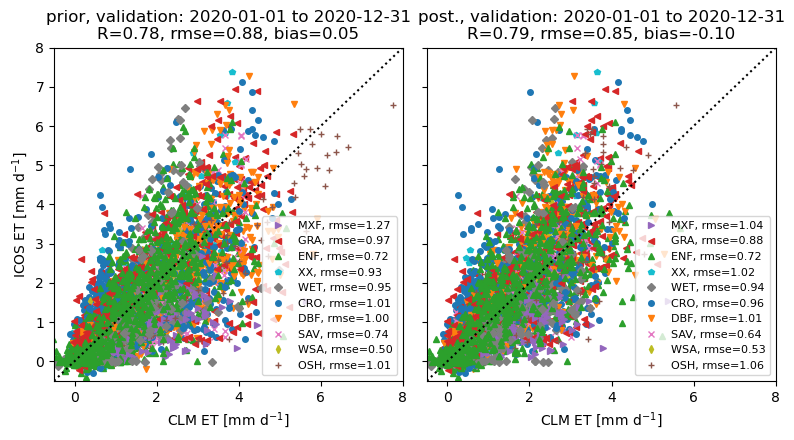

In [8]:
### Validation, prior & posterior

# date_start = pd.Timestamp(2019,5,1)
# date_val = pd.Timestamp(2019,8,1)
# date_end = pd.Timestamp(2020,8,1)

fig,axes = plt.subplots(1,2,figsize=(8,4.5))

modes = ['prior','post.']
keys_save = ['val_prior','val_post']
for i_,i_real in enumerate([i_OL,i_DA]):
   
    mode_ = modes[i_]
    key_save = keys_save[i_]
    stats_per_station['val'][mode_] = {}
        
    x_cover = {}
    y_cover = {}
    n_cover = {}
    list_covers = [operator['FLX'].data_flx[station_]['landcover'] for station_ in operator['FLX'].data_flx.keys()]
    covers_unique = np.unique(list_covers)
    cmap = plt.cm.tab10
    markers = ["o", "v", "^", "<", ">", "+", "x", "D", "d", "p", "P","1", "2", "3", "4", "s", "*", "h", "H", "X" ]

    x_all = np.array([])
    y_all = np.array([])
    
    for station_ in operator['FLX'].data_flx.keys():
     
        cover = operator['FLX'].data_flx[station_]['landcover']
        i_cover = np.where(cover==covers_unique)[0][0]
    
        dates = np.array(list(results[i_real]['FLX'][station_].keys()))
        if dates[-1] > date_val:
            i_date_start = np.where(dates > date_val)[0][0]
            
            x_ = np.array([float(results[i_real]['FLX'][station_][key_]) for key_ in results[i_real]['FLX'][station_].keys()])[i_date_start:]
            y_ = np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[i_date_start:]
            if cover not in x_cover:
                x_cover[cover] = np.array([])
                y_cover[cover] = np.array([])
                n_cover[cover] = 0
                label_ = cover
            else:
                label_ = None

            x_cover[cover] = np.append(x_cover[cover],x_)
            y_cover[cover] = np.append(y_cover[cover],y_)

            axes[i_].plot(x_,y_,markers[i_cover],markersize=4,color=cmap(i_cover),label=label_)

            if len(x_) > 1:
                x_all = np.append(x_all,x_)
                y_all = np.append(y_all,y_)
                stats_per_station['val'][mode_][station_] = {}
                stats_per_station['val'][mode_][station_]['x'] = x_
                stats_per_station['val'][mode_][station_]['x'] = y_
                stats_per_station['val'][mode_][station_]['rmse'] = np.sqrt(np.mean((x_-y_)**2))
                stats_per_station['val'][mode_][station_]['R'] = pearsonr(x_,y_)[0]
                stats_per_station['val'][mode_][station_]['bias'] = np.mean(x_-y_)

                stats_per_station['val'][mode_][station_]['lat'] = operator['FLX'].data_flx[station_]['lat']
                stats_per_station['val'][mode_][station_]['lon'] = operator['FLX'].data_flx[station_]['lon']
                stats_per_station['val'][mode_][station_]['cover'] = cover
            n_cover[cover] += 1

    handles,labels_ = axes[i_].get_legend_handles_labels()
    for i1,cover_ in enumerate(labels_):
        R = pearsonr(x_cover[cover_],y_cover[cover_])[0]
        rmse = np.sqrt(np.mean((x_cover[cover_]-y_cover[cover_])**2))
        bias = np.mean(x_cover[cover_]-y_cover[cover_])
        
        print('%s, R=%f, rmse=%f, bias=%f' % (cover_,R,rmse,bias) )
        # cover_ = cover_ + ', R=%2.2f, rmse=%2.2f, bias=%2.2f'%(R,rmse,bias)
        cover_ = cover_ + ', rmse=%2.2f'%(rmse)
        labels_[i1] = cover_

    # ax_.legend(handles, labels_)

    # y_all = operator['FLX'].flatten_y(operator['FLX'].data_flx,'LE_CORR')
    # x_all = operator['FLX'].flatten_y(results[i_real]['FLX'])
    R_all = pearsonr(x_all,y_all)[0]
    rmse_all = np.sqrt(np.mean((x_all-y_all)**2))
    bias_all = np.mean(x_all-y_all)
    
    stats_save['FLX'][key_save] = {}
    stats_save['FLX'][key_save]['rmse'] = rmse_all
    stats_save['FLX'][key_save]['R'] = R_all
    stats_save['FLX'][key_save]['bias'] = bias_all

    axes[i_].legend(handles,labels_,fontsize=8,loc='lower right')
    axes[i_].set_title('%s, validation: %s to %s\nR=%2.2f, rmse=%2.2f, bias=%2.2f' % (modes[i_],str(date_plot[2])[0:10],str(date_plot[3])[0:10],
                                                                          R_all,rmse_all,bias_all))
    
    print('Realization %i' % i_real)
    print('all landcovers: R=%f, rmse=%f, bias=%f' % (R_all,rmse_all,bias_all) )

min_ = -0.5
max_ = 8

axes[1].tick_params(labelleft=False)

axes[0].set_xlim(min_,max_)
axes[1].set_xlim(min_,max_)
axes[0].set_ylim(min_,max_)
axes[1].set_ylim(min_,max_)
axes[0].set_xlabel('CLM ET [mm d$^{-1}$]')
axes[1].set_xlabel('CLM ET [mm d$^{-1}$]')
axes[0].set_ylabel('ICOS ET [mm d$^{-1}$]')
axes[0].plot([min_,max_],[min_,max_],'k:')
axes[1].plot([min_,max_],[min_,max_],'k:')
fig.tight_layout()

fig.savefig(os.path.join(dir_figs,'corr_ICOS_val.png') )
fig.savefig(os.path.join(dir_figs,'corr_ICOS_val.pdf') )

pickle_filename3 = os.path.join(dir_figs,'plot_03_ICOS_stats_per_station.pickle')
save_dict_to_pickle(stats_per_station,pickle_filename3)

pickle_filename4 = os.path.join(dir_figs,'stats_overall.pickle')
save_dict_to_pickle(stats_save,pickle_filename4)



In [10]:

dev_timeseries = {}

for i_ in [i_OL,i_DA]:

    clm_vals = operator['SMAP'].flatten_y(results[i_]['SMAP'])
    lats_select = np.array([20,30,40,50,60,70])

    dev_per_latitude = {}

    for i1,(lat_1,lat_2) in enumerate(zip(lats_select[:-1],lats_select[1:])):
        lat_mean = .5*(lat_1+lat_2)
        mask_lat = (smap_latlon[:,0] > lat_1) & (smap_latlon[:,0] <= lat_2)
        dates = smap_dates[mask_lat]

        dates_unique = np.unique(dates)
        results_dates = [[]]
        results_rmse = [[]]
        results_mdev = [[]]

        for i2,date_ in enumerate(dates_unique[:-1]):
            mask_lat_date = mask_lat & (smap_dates == dates_unique[i2])
            
            if mask_lat_date.sum() > 10:
                rmse = np.sqrt(np.mean((smap_vals[mask_lat_date]-clm_vals[mask_lat_date])**2))
                mdev = np.mean(clm_vals[mask_lat_date]-smap_vals[mask_lat_date])
                results_dates[-1].append(dates_unique[i2])
                results_rmse[-1].append(rmse)
                results_mdev[-1].append(mdev)

                if dates_unique[i2+1]-dates_unique[i2] > timedelta(days=6):
                    results_dates.append([])
                    results_rmse.append([])
                    results_mdev.append([])
                if i2 % 5 == 0:
                    print(date_)

        dev_per_latitude[lat_mean] = {}
        dev_per_latitude[lat_mean]['dates'] = results_dates
        dev_per_latitude[lat_mean]['rmse'] = results_rmse
        dev_per_latitude[lat_mean]['mdev'] = results_mdev

    dev_timeseries[i_] = copy.deepcopy(dev_per_latitude)
    
save_dict_to_pickle(dev_timeseries,pickle_filename2)

2019-01-04 20:00:00
2019-01-19 20:00:00
2019-02-03 20:00:00
2019-02-18 20:00:00
2019-03-05 20:00:00
2019-03-20 20:00:00
2019-04-04 20:00:00
2019-04-19 20:00:00
2019-05-04 20:00:00
2019-05-19 20:00:00
2019-06-03 20:00:00
2019-06-18 20:00:00
2019-08-05 20:00:00
2019-08-20 20:00:00
2019-09-04 20:00:00
2019-09-19 20:00:00
2019-10-04 20:00:00
2019-10-19 20:00:00
2019-11-03 20:00:00
2019-11-18 20:00:00
2019-12-03 20:00:00
2019-12-18 20:00:00
2020-01-02 20:00:00
2020-01-17 20:00:00
2020-02-01 20:00:00
2020-02-16 20:00:00
2020-03-03 20:00:00
2020-03-18 20:00:00
2020-04-02 20:00:00
2020-04-17 20:00:00
2020-05-02 20:00:00
2020-05-17 20:00:00
2020-06-01 20:00:00
2020-06-16 20:00:00
2020-07-01 20:00:00
2020-07-16 20:00:00
2020-07-31 20:00:00
2020-08-15 20:00:00
2020-08-30 20:00:00
2020-09-14 20:00:00
2020-10-02 20:00:00
2020-10-17 20:00:00
2020-11-01 20:00:00
2020-11-16 20:00:00
2020-12-01 20:00:00
2020-12-16 20:00:00
2019-01-04 20:00:00
2019-01-19 20:00:00
2019-02-03 20:00:00
2019-02-18 20:00:00


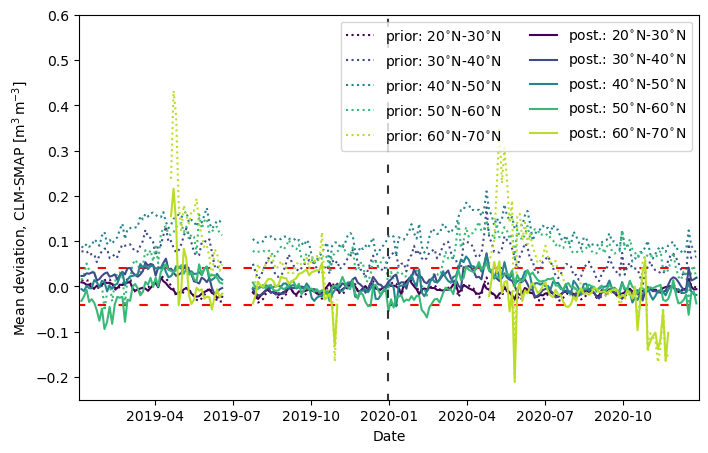

In [15]:
%matplotlib inline
import matplotlib.colors as mcolors

# Define the original colormap
original_cmap = plt.cm.viridis
# Extract colormap colors
colors = original_cmap(np.linspace(0, 1, 256))
# Create a truncated colormap, excluding the upper 20%
truncated_colors = colors[int(0.0 * len(colors)):int(0.9 * len(colors))]
# Create a new colormap with the truncated colors
truncated_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_inferno', truncated_colors)

fig,ax = plt.subplots(1,figsize=(8,5))
lstyles = [':','-']
c1=0
c2=0
lats_select = np.array([20,30,40,50,60,70])
modes = ['prior','post.']
for i2,i_ in enumerate([i_OL,i_DA]):
    dev_per_latitude = dev_timeseries[i_]
    
    for i1,lat_mean in enumerate(dev_per_latitude.keys()):
        lat_1 = lats_select[i1]
        lat_2 = lats_select[i1+1]
        cval = (lat_1-lats_select[0]) / (lats_select[-2]-lats_select[0])
        
        c2 = 0
        for x_,y_ in zip(dev_per_latitude[lat_mean]['dates'],dev_per_latitude[lat_mean]['mdev']):
            if c2==0:
                label_ = r'%s: %i$^{\circ}$N-%i$^{\circ}$N'%(modes[i2],lat_1,lat_2)
            else:
                label_ = None
            ax.plot(x_,y_,color=truncated_cmap(cval),label=label_,linestyle=lstyles[c1])
            c2 += 1
    c1 += 1
    
ymin = -.25
ymax=.6
ax.plot([date_val,date_val],[ymin,ymax],'k',linestyle=(1, (4, 6)),alpha=.8)
date_min = date_start#datetime(2019,4,15)
date_max = date_end#datetime(2020,8,15)

ax.set_ylim(ymin,ymax)
ax.set_xlim(date_min,date_max)
ax.legend(ncol=2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean deviation, CLM-SMAP [m$^3\,$m$^{-3}$]')

ax.plot([date_min,date_max],[-0.04,-0.04],'r',linestyle=(1, (4, 6)),zorder=-1000)
ax.plot([date_min,date_max],[+0.04,+0.04],'r',linestyle=(1, (4, 6)),zorder=-1000)

fig.savefig(os.path.join(dir_figs,'mismatch_lat_timeseries.png') )
fig.savefig(os.path.join(dir_figs,'mismatch_lat_timeseries.pdf') )



/tmp/ipykernel_9431/2909658041.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(ax1)


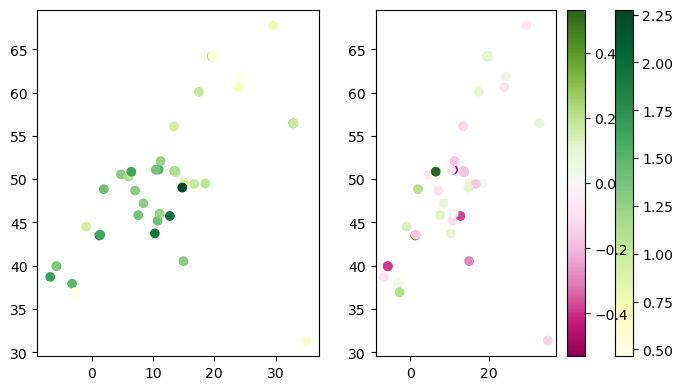

In [196]:
mode_ = 'train'

all_rmse_OL = np.array([stats_per_station[mode_]['OL'][station_]['rmse'] for station_ in stats_per_station[mode_]['OL'].keys()])
all_rmse_DA = np.array([stats_per_station[mode_]['DA'][station_]['rmse'] for station_ in stats_per_station[mode_]['OL'].keys()])
all_lat_OL = np.array([stats_per_station[mode_]['OL'][station_]['lat'] for station_ in stats_per_station[mode_]['OL'].keys()])
all_lon_OL = np.array([stats_per_station[mode_]['OL'][station_]['lon'] for station_ in stats_per_station[mode_]['OL'].keys()])

diff = all_rmse_DA - all_rmse_OL
maxval = np.max(np.abs(diff))

fig,axes = plt.subplots(1,2,figsize=(8,4.5))
ax1=axes[0].scatter(all_lon_OL,all_lat_OL,c=all_rmse_OL,cmap=plt.cm.YlGn)
plt.colorbar(ax1)
ax2=axes[1].scatter(all_lon_OL,all_lat_OL,c=diff,cmap=plt.cm.PiYG,vmin=-maxval,vmax=maxval)
plt.colorbar(ax2)
